# Peak Count Normalization

**Created**: 6 December 2021

## Environment

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

if (!requireNamespace("Rtsne")) {
    install.packages("Rtsne")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: Rtsne

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)
library(limma)
library(Rtsne)
library(UpSetR)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: limma



## Load Data

In [3]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Lineage, Cell_type, Stimulated, Treatment) %>%
    dplyr::mutate(DA.Treatment=ifelse(Cell_type == "Neutrophils" & Stimulated, Treatment, ifelse(Stimulated, "Stimulated", "Baseline"))) %>%
    unique() %>%
    dplyr::arrange(Lineage, Cell_type, Treatment, Donor)

# Ignore whole-organism stimulation
sample.info <- sample.info %>%
    dplyr::filter(!grepl("SA", Group.ID) & !grepl("EC", Group.ID))

rownames(sample.info) <- sample.info$Group.ID

In [4]:
head(sample.info)

,Group.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,DA.Treatment
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,Calderon-1001,B,Bulk_B,FALSE,Control,Baseline
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon-1002,B,Bulk_B,FALSE,Control,Baseline
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon-1003,B,Bulk_B,FALSE,Control,Baseline
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon-1004,B,Bulk_B,FALSE,Control,Baseline
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001,B,Bulk_B,TRUE,Treatment_1,Stimulated
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,Calderon-1002,B,Bulk_B,TRUE,Treatment_1,Stimulated


In [5]:
peak.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) { x[1] })

peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(sample.info$Group.ID))

In [6]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,Calderon-1001-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,⋯,Calderon-1003-Mature_NK-Treatment_1,Calderon-1004-Mature_NK-Treatment_1,Calderon-1008-Mature_NK-Treatment_2,Calderon-1010-Mature_NK-Treatment_2,Calderon-1001-Memory_NK-Control,Calderon-1002-Memory_NK-Control,Calderon-1003-Memory_NK-Control,Calderon-1004-Memory_NK-Control,Calderon-1008-Memory_NK-Control,Calderon-1010-Memory_NK-Control
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:27069-27323,1,27069,27323,+,4,9,2,4,6,⋯,3,14,9,10,3,6,3,2,10,8
1:28482-30136,1,28482,30136,+,535,113,109,153,648,⋯,191,273,258,177,437,118,38,438,305,178
1:30498-30843,1,30498,30843,+,8,10,9,9,11,⋯,3,15,12,5,2,17,1,3,16,11
1:30968-31928,1,30968,31928,+,24,21,8,21,18,⋯,10,24,39,25,11,32,5,18,46,33
1:32133-32341,1,32133,32341,+,2,4,1,6,6,⋯,3,17,12,8,3,7,0,2,14,5
1:32469-33306,1,32469,33306,+,10,30,8,24,17,⋯,7,38,33,29,9,44,5,17,42,31


In [7]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

rownames(tss.enrichment) <- tss.enrichment$Sample

tss.enrichment <- tss.enrichment[sample.info$Group.ID, ]

In [8]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,18.774876
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,4.386867
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,16.051261
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,8.836709
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,19.764036
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,14.453559


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [9]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

### Create Sample Groups for Immune Atlas

The Calderon *et al.* and Corces *et al.* studies share cell types. Therefore, they can be analyzed in the same analysis (that is, the design matrix is of the proper rank).

In [10]:
study.samples <- grepl("(Corces|Calderon)", sample.info$Donor)

Subset the count matrix based on the samples in either Calderon *et al.* or Corces *et al.*

In [11]:
count.mtx.ia <- count.mtx[, study.samples]

Biological groups will be defined by cell types and stimulation condition.

In [12]:
cell.type <- factor(sample.info$Cell_type[study.samples])
stimulated <- factor(sample.info$DA.Treatment[study.samples])
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [13]:
donors <- factor(sample.info$Donor[study.samples])
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score[study.samples])

Design matrix for the immune atlas.

In [14]:
design.ia <- model.matrix(~0 + groups + donors + tss.score)

### Create Sample Groups for Neutrophil Atlas

The Ram-Mohan *et al.* study does not overlap with the other two studies and will be analyzed separately to maintain a design matrix of proper rank.

In [15]:
study.samples <- grepl("Ram-Mohan", sample.info$Donor)

Subset the count matrix based on the samples in Ram-Mohan *et al.*

In [16]:
count.mtx.rm <- count.mtx[, study.samples]

Biological groups will be defined by specific stimulation condition. The stimulation condition have a higher resolution in this study (multiple treatments across donors).

In [17]:
stimulated <- factor(sample.info$DA.Treatment[study.samples])
stimulated <- droplevels(stimulated)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [18]:
donors <- factor(sample.info$Donor[study.samples])
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score[study.samples])

Design matrix for the neutrophil atlas.

In [19]:
design.rm <- model.matrix(~0 + stimulated + donors + tss.score)

### Create DGEList for Immune Atlas

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [20]:
dge.ia <- DGEList(count.mtx.ia)

Filter peaks using in-built `edgeR` function.

In [21]:
keep <- filterByExpr(dge.ia, design=design.ia)
dge.ia <- dge.ia[keep, , keep.lib.sizes=FALSE]

In [22]:
dim(dge.ia)

[1] 520693    178

Calculate normalization factors for the trimmed mean of M-values method.

In [23]:
dge.ia <- calcNormFactors(dge.ia, method="TMM")

### Create DGEList for Neutrophil Atlas

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [24]:
dge.rm <- DGEList(count.mtx.rm)

Filter peaks using in-build `edgeR` function.

In [25]:
keep <- filterByExpr(dge.rm, design=design.rm)
dge.rm <- dge.rm[keep, , keep.lib.sizes=FALSE]

In [26]:
dim(dge.rm)

[1] 429425     30

Calculate normalization factors for the trimmed mean of M-values method.

In [27]:
dge.rm <- calcNormFactors(dge.rm, method="TMM")

### Voom for Immune Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

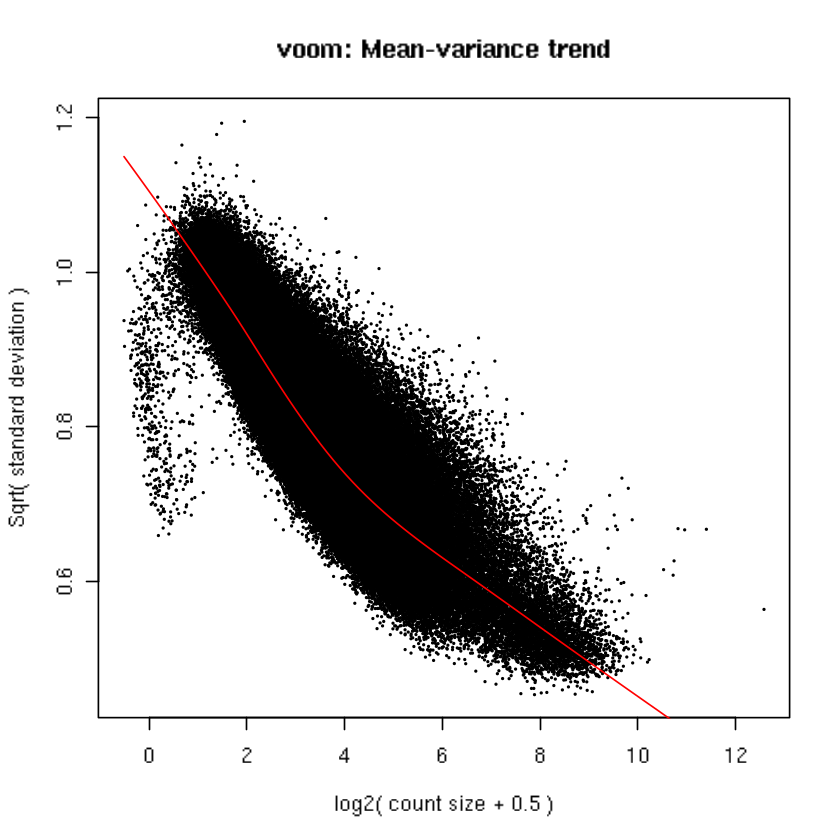

In [28]:
y.ia <- voom(dge.ia, design.ia, plot=TRUE)

### Voom for Neutrophil Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

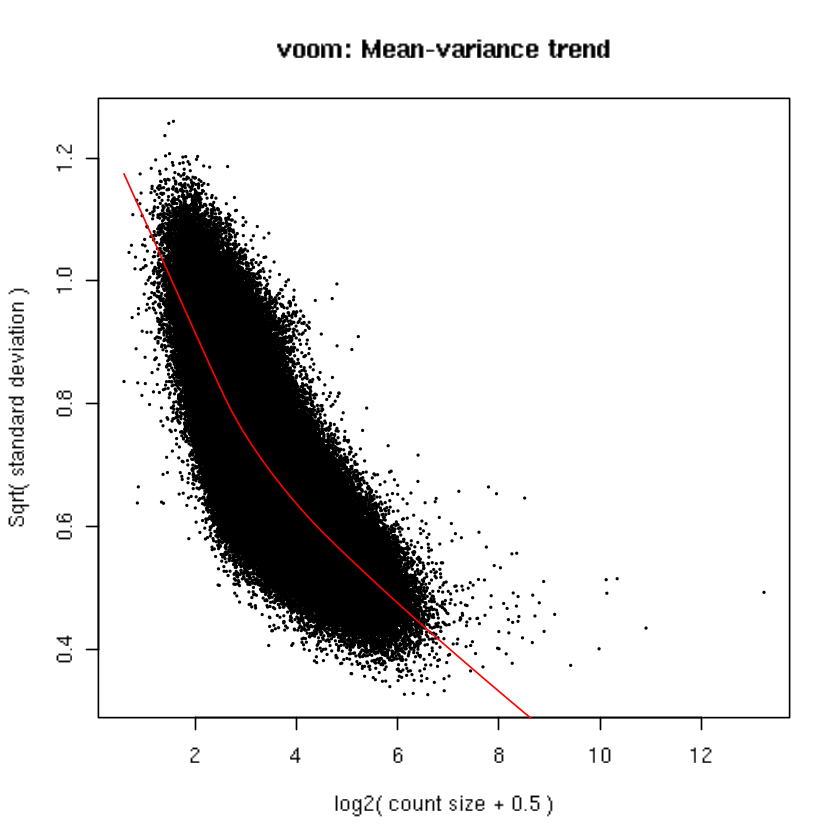

In [29]:
y.rm <- voom(dge.rm, design.rm, plot=TRUE)

### Visualize Normalized Counts

In [30]:
pca.ia <- prcomp(t(as.matrix(y.ia)))
pca.rm <- prcomp(t(as.matrix(y.rm)))

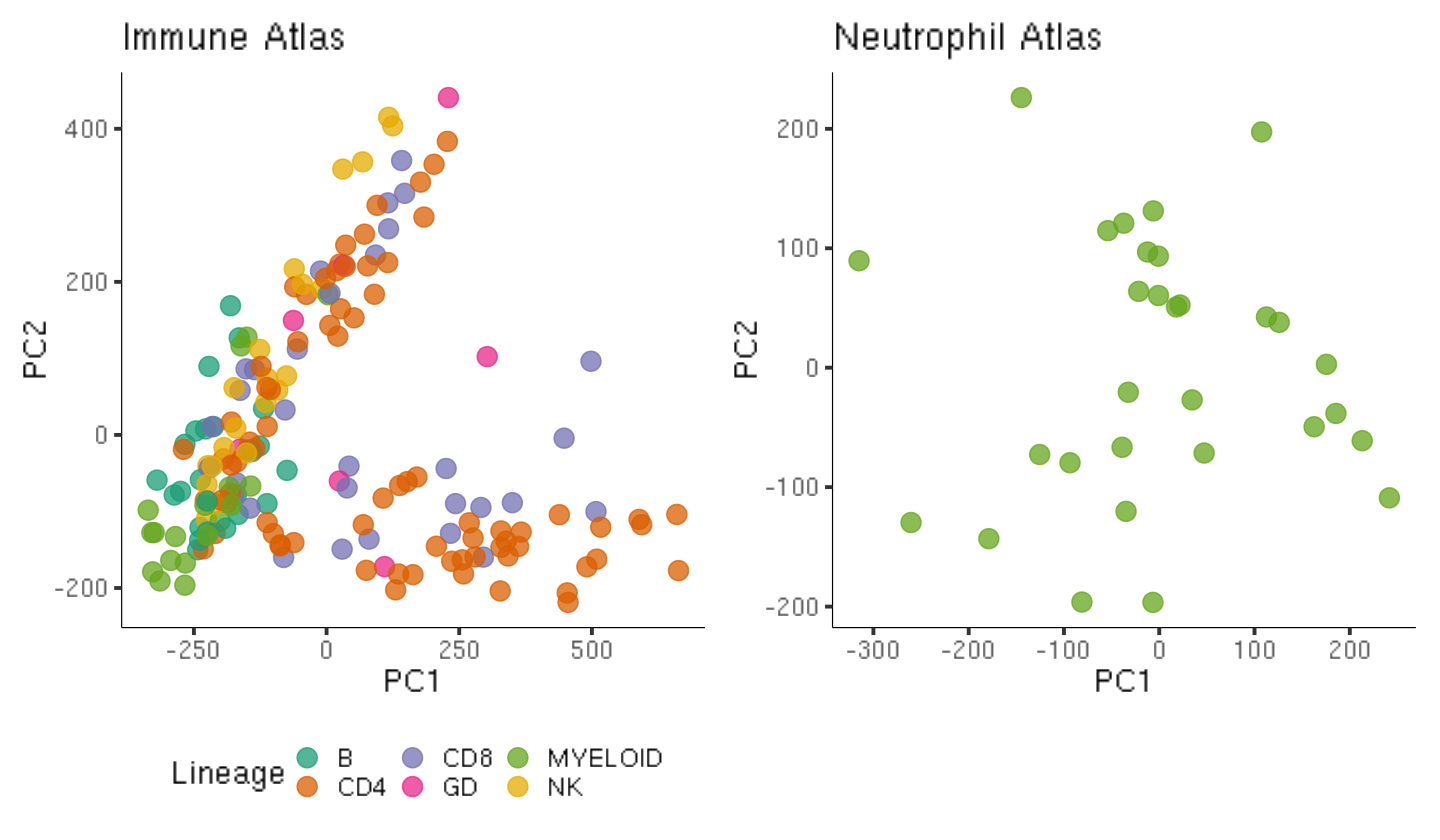

In [31]:
options(repr.plot.width=12, repr.plot.height=7)

p <- merge(pca.ia$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggtitle("Immune Atlas") +
    ggplot_theme

q <- merge(pca.rm$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2), size=I(5), alpha=0.75, color=brewer.pal("Dark2", n=5)[5]) +
    ggtitle("Neutrophil Atlas") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/normalized_peak_count_pca.svg", width=12, height=7)

In [32]:
control.samples <- sample.info$Group.ID[sample.info$DA.Treatment == "Baseline"]
control.samples <- control.samples[grepl("(Corces|Calderon)", control.samples)]

set.seed(89734987)
tsne.res <- Rtsne(t(as.matrix(y.ia)[, control.samples]), num_threads=15, perplexity=5)

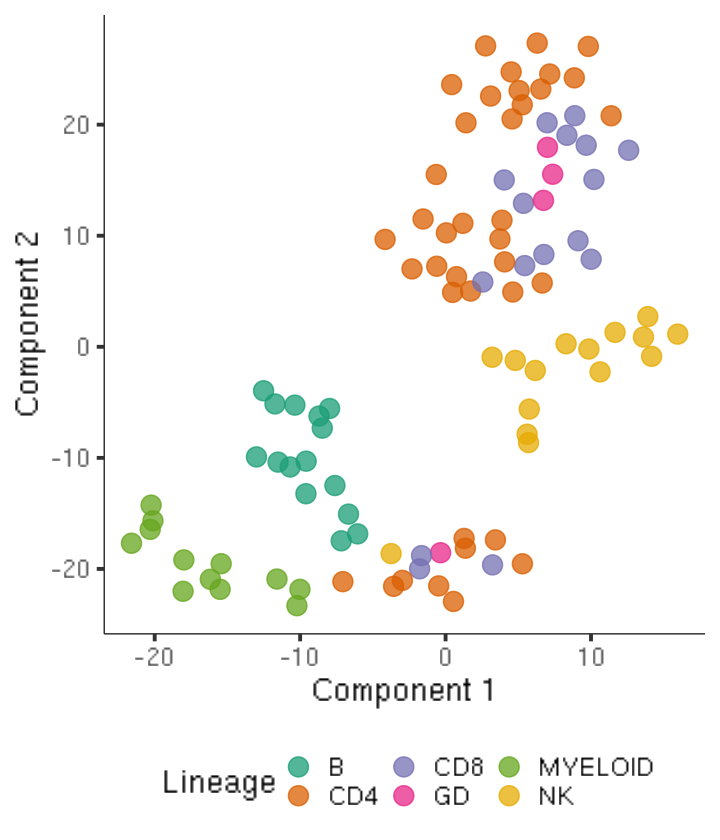

In [33]:
options(repr.plot.width=6, repr.plot.height=7)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Sample=control.samples) %>%
    merge(., sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_peak_count_tsne.svg", width=6, height=7)

### Limma Fit

Use `limma` to fit a linear model consisting of the biological `groups`.

In [34]:
fit.ia <- lmFit(y.ia, design.ia)

In [35]:
fit.rm <- lmFit(y.rm, design.rm)

### Limma DA Peaks for Immune Atlas

Identify all cell types where both the baseline and stimulated conditions are present.

In [36]:
cell.type.conditions <- sample.info %>%
    dplyr::filter(grepl("(Corces|Calderon)", Group.ID)) %>%
    dplyr::select(Cell.Type=Cell_type, DA.Treatment) %>%
    dplyr::group_by(Cell.Type, DA.Treatment) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(DA.Treatment, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [37]:
contrast <- matrix(0, nrow=ncol(coef(fit.ia)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit.ia))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [38]:
da.peaks.ia <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit.ia, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Cell.Type, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

### Limma DA Peaks for Neutrophil Atlas

Create contrasts for each treatment.

In [39]:
treatments <- setdiff(sample.info$DA.Treatment[grepl("Ram-Mohan", sample.info$Group.ID)], "Baseline")

In [40]:
contrast <- matrix(0, nrow=ncol(coef(fit.rm)), ncol=length(treatments))
rownames(contrast) <- colnames(coef(fit.rm))
colnames(contrast) <- paste0(treatments, "-Baseline")

for (i in 1:length(treatments)) {
    contrast[paste0("stimulated", treatments[i]), i] = 1
    contrast["stimulatedBaseline", i] = -1
}

In [41]:
da.peaks.rm <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit.rm, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)

    treatment = strsplit(colnames(contrast)[i], "-")[[1]][1]

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Treatment=treatment) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Treatment, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

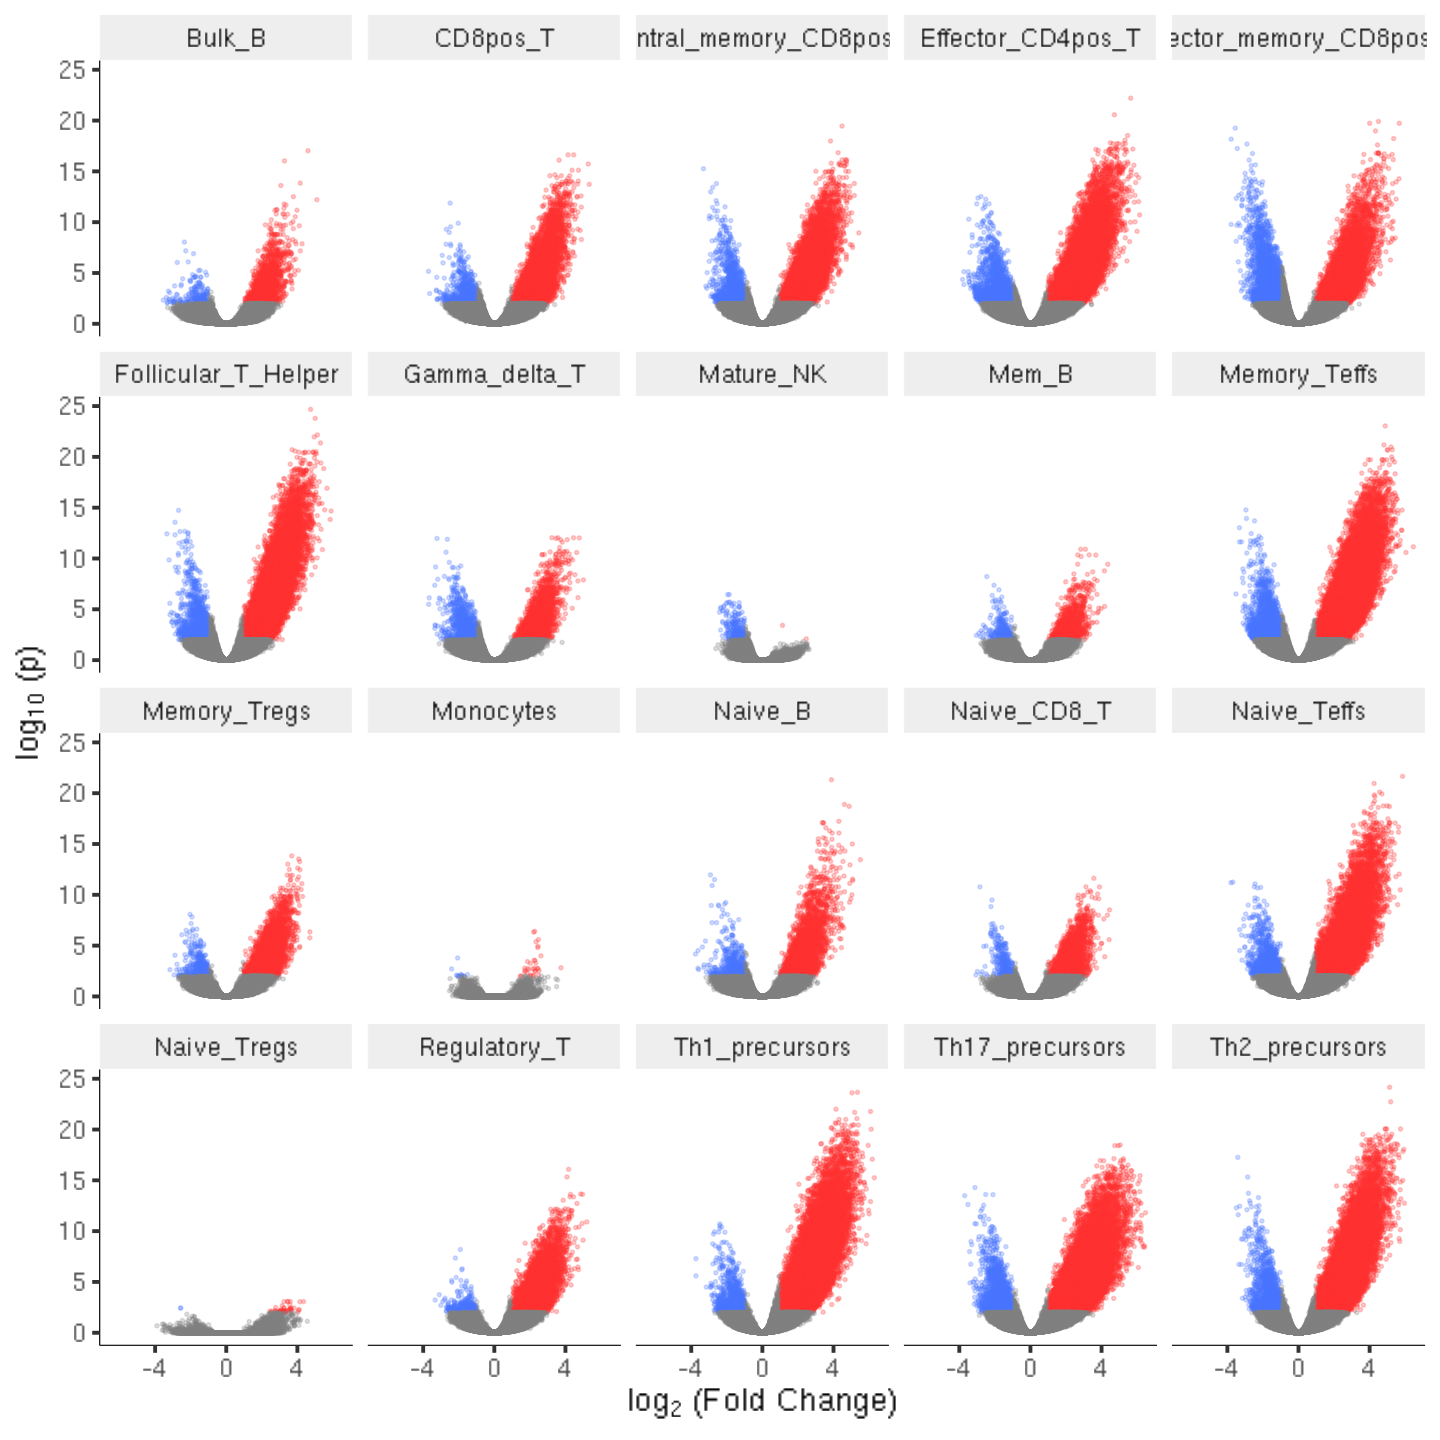

In [48]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(da.peaks.ia$logFC))

da.peaks.ia %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/da_peaks_ia_volcano_plots.png", width=12, height=12)

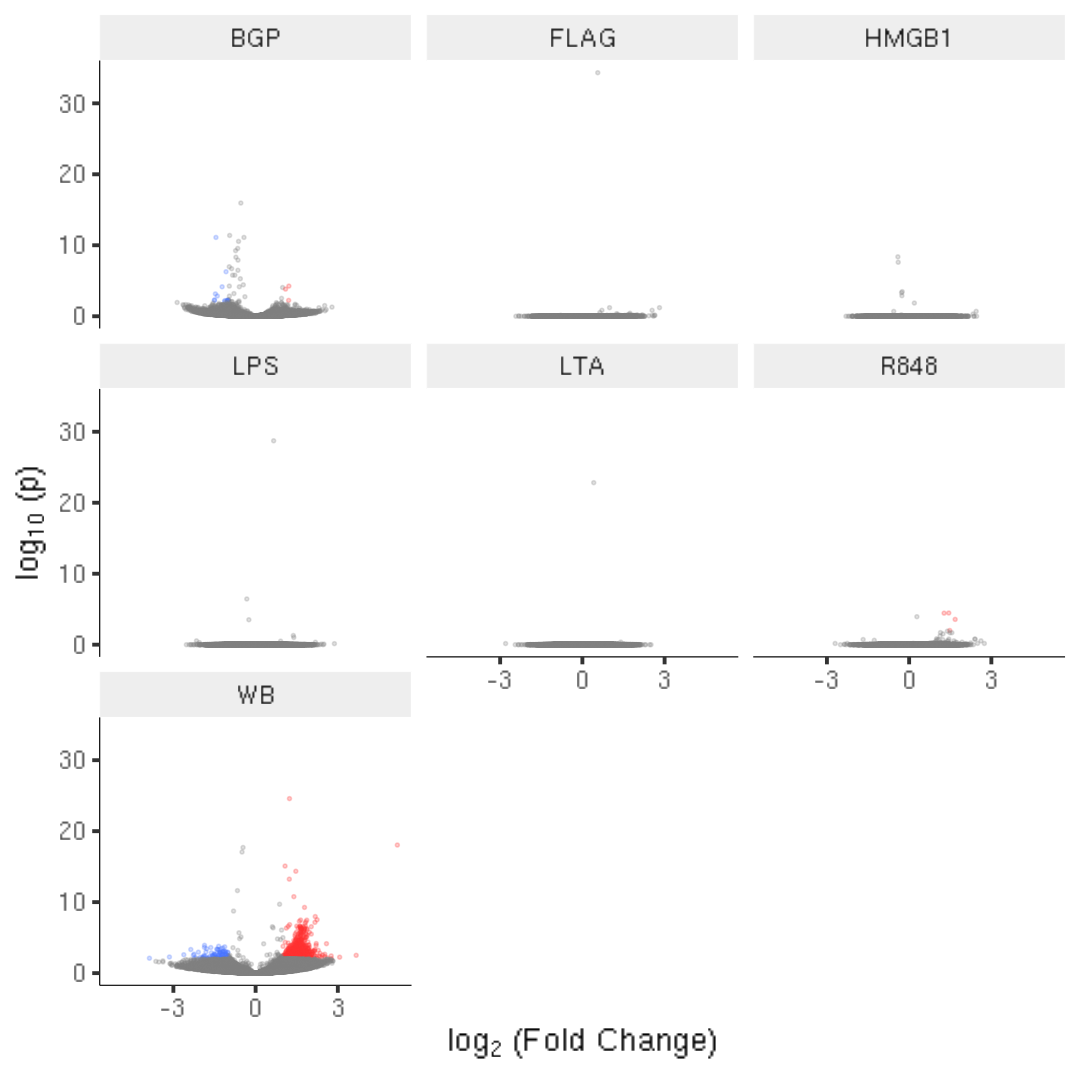

In [51]:
options(repr.plot.width=9, repr.plot.height=9)

abs.max.log.fc <- max(abs(da.peaks.rm$logFC))

da.peaks.rm %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Treatment)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/da_peaks_rm_volcano_plots.png", width=9, height=9)

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

In [52]:
da.peak.set.ia <- da.peaks.ia %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(da.peak.set.ia, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_ia_set.csv")

da.peak.set.rm <- da.peaks.rm %>%
    dplyr::filter(adj.P.Val < 0.01) %>%
    dplyr::filter(abs(logFC) > 1)

write.csv(da.peak.set.rm, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_rm_set.csv")

There are 65289 total peaks that are DA peaks in at least one cell type in the immune atlas. There are 978 peaks that are DA peaks in at least one treatment for neutrophils.

In [53]:
length(unique(da.peak.set.ia$Peak.ID))

length(unique(da.peak.set.rm$Peak.ID))

[1] 65289

[1] 978

In [54]:
table(da.peak.set.ia$Cell.Type)


                  Bulk_B                 CD8pos_T  Central_memory_CD8pos_T 
                    2343                    11672                    17178 
       Effector_CD4pos_T Effector_memory_CD8pos_T      Follicular_T_Helper 
                   25194                    15890                    25000 
           Gamma_delta_T                Mature_NK                    Mem_B 
                    4474                      292                     1738 
            Memory_Teffs             Memory_Tregs                Monocytes 
                   32962                     5776                       45 
                 Naive_B              Naive_CD8_T              Naive_Teffs 
                    4444                     3389                    19934 
             Naive_Tregs             Regulatory_T           Th1_precursors 
                      53                     8766                    32167 
         Th17_precursors           Th2_precursors 
                   25923            

In [55]:
table(da.peak.set.rm$Treatment)


 BGP R848   WB 
  16    4  958 